In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, zero_one_loss

%matplotlib inline

In [2]:
# Loading the data
df = pd.read_csv('data/mulcross.csv')

df['Target'] = df.Target.apply(lambda r: 1 if r=="'Normal'" else -1)
df

,V1,V2,V3,V4,Target
0,-0.203950,0.363011,1.013766,0.187131,1
1,-0.761118,2.436424,0.681846,0.654366,1
2,-0.209979,1.131098,-0.282180,-0.202210,1
3,0.836812,0.650342,-0.426900,-0.305281,1
4,0.454204,1.560128,-0.204841,0.219233,1
...,...,...,...,...,...
262139,-0.699533,-1.110000,-0.084369,-0.575921,1
262140,-1.972119,0.965250,-0.240917,0.463352,1
262141,-0.327949,-1.702591,-0.031113,-0.759623,1
262142,-2.080999,-0.185966,-0.518695,-0.829814,1


In [3]:
features = ['V1','V2','V3','V4']

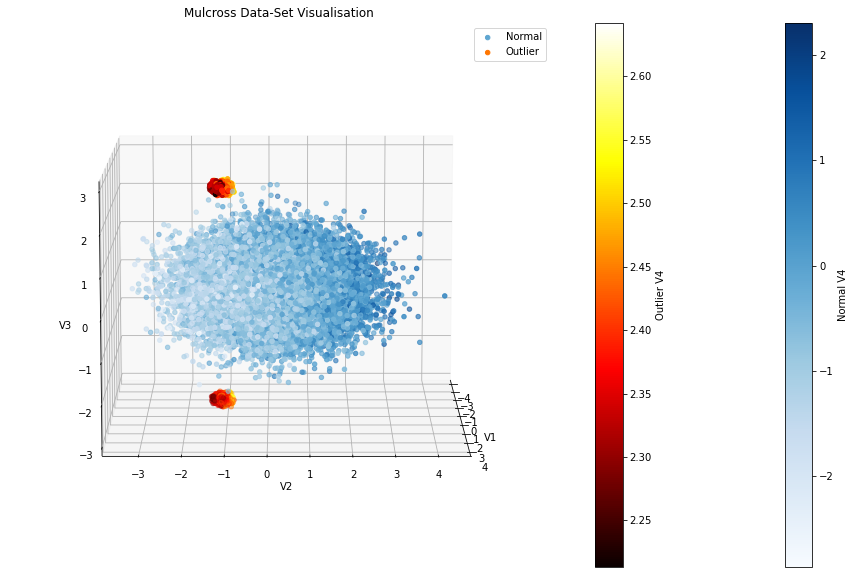

In [5]:
from mpl_toolkits.mplot3d import Axes3D

df_s = df.sample(frac=0.1, random_state=1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

normal = ax.scatter(df_s[df_s.Target==1].V1, df_s[df_s.Target==1].V2, 
                    df_s[df_s.Target==1].V3, c=df_s[df_s.Target==1].V4, 
                    cmap='Blues')

outlier = ax.scatter(df_s[df_s.Target==-1].V1, df_s[df_s.Target==-1].V2, 
                     df_s[df_s.Target==-1].V3, c=df_s[df_s.Target==-1].V4, 
                     cmap=plt.hot())

ax.view_init(10, 360)

fig.colorbar(normal, label='Normal V4')
fig.colorbar(outlier, label='Outlier V4')

plt.legend(['Normal','Outlier'])
ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_zlabel('V3')
ax.set_title('Mulcross Data-Set Visualisation')

plt.savefig('Mulcross')
plt.show()

In [ ]:
# N-Folds Cross Validation
def N_folds_CV(X, y, n, model):
    
    """
    Performs N-folds cross-validation on the data (predictors X, observed output y) with a given model.
    
    :param X: Predictors
    :param y: Observed output
    :param n: number of folds 
    :param model: model to fit
    
    :return: array of N R-squared scores
    """
    
    cv = KFold(n_splits=n)
    cv_clf = model
    cv_score = []
            
    for train, test in cv.split(X, y):
        cv_reg = cv_clf.fit(X.iloc[train])
        y_diff = cv_reg.predict(X.iloc[train]) - y.iloc[train]
        cv_score.append(y_diff[y_diff != 0].size)
                
    return np.asarray(cv_score)

In [4]:
import itertools
from joblib import Parallel, delayed
import multiprocessing
    
df_s = df.sample(frac=0.1, random_state=1) # too long calculation

def score_fun(estimator, X, y):
    y_diff = estimator-y
    return y_diff[y_diff != 0].size

# Tuning hyper-parameters using N_folds Cross Validation
X_train, X_test, y_train, y_test = train_test_split(df_s[features], df_s['Target'], test_size=0.33, random_state=42)    
    
gamma = [0.5, 0.1, 0.01, 0.001, 0.0001]
nu    = [0.25, 0.5, 0.75, 0.95]

inputs = list(itertools.product(gamma, nu))

def processInput(gamma,nu):
    clf = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    # N_folds_CV(X_train, y_train, 10, OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)).mean()
    return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring=make_scorer(zero_one_loss)))
 
num_cores = multiprocessing.cpu_count()-2
     
results = Parallel(n_jobs=num_cores)(delayed(processInput)(gamma,nu) for gamma,nu in inputs)

In [5]:
# Saving the results
p_tab = pd.DataFrame(columns=['gamma','nu','miss'])

for i in range(0,len(results)):
    p_tab.loc[len(p_tab)] = [inputs[i][0], inputs[i][1], results[i]]
    
p_tab

,gamma,nu,miss
0,0.5000,0.25,0.273644
1,0.5000,0.50,0.398509
2,0.5000,0.75,0.648466
3,0.5000,0.95,0.848204
4,0.1000,0.25,0.147983
5,0.1000,0.50,0.398338
6,0.1000,0.75,0.648580
7,0.1000,0.95,0.847976
8,0.0100,0.25,0.147698
9,0.0100,0.50,0.397541


In [6]:
best_cv = p_tab.loc[p_tab['miss'].idxmin()]
print(best_cv)

gamma    0.000100
nu       0.250000
miss     0.147698
Name: 16, dtype: float64


In [7]:
clf = OneClassSVM(kernel='rbf', gamma=best_cv[0], nu=best_cv[1])
clf.fit(X_train)

y_pred = clf.predict(X_test)

error = (y_test - y_pred)
error = 100 * (error[error != 0].size / len(error))

In [8]:
print('Miss Classification error = %.2f %%' % error)

Miss Classification error = 14.66 %


In [9]:
# Testing on all the data
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Target'], test_size=0.33, random_state=42)   

clf = OneClassSVM(kernel='rbf', gamma=best_cv[0], nu=best_cv[1])
clf.fit(X_train)

y_pred = clf.predict(X_test)

In [13]:
nb_outliers = y_test[y_test==-1].size
diff = y_test - y_pred

refused_normal = 100 * (diff[diff == 2].size) / len(diff)
accepted_outliers = 100 * (diff[diff == -2].size) / len(diff)
error = refused_normal+accepted_outliers

print('Normal   = %.2f %% - Refused Normal    = %.2f %%' % (100*(1-nb_outliers/len(y_test)), refused_normal))
print('Outliers = %.2f %% - Accepted Outliers = %.2f %%' % (100*nb_outliers/len(y_test), accepted_outliers))
print()
print('Miss Classification error = %.2f %%' % error)

Normal   = 89.99 % - Refused Normal    = 14.89 %
Outliers = 10.01 % - Accepted Outliers = 0.00 %

Miss Classification error = 14.89 %
